# This Code does the DyCA Analysis of the sEEG Data from EBRAINS (Amir)

- First try to handle the data in the propper manner (xarray)


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dyca

In [2]:
test_array = xr.load_dataarray("/home/astiehl/05_Code/Promotion/marseille/IREM/seeg_epochs/HID-Sub-001_MVIS_MVEB_Epochs.nc")
# count nans and notnans in the data
nans = np.isnan(test_array).sum().item()
notnans = np.count_nonzero(~np.isnan(test_array))

print(f"Number of NaNs in the data array: {nans}")
print(f"Number of non-NaNs in the data array: {notnans}")

# maybe i can reconstruct the number of datapoints
total_points = nans + notnans
total_points2 = test_array.size
total_points3 = 256*93*2*2*2*36
print(f"Total number of data points (nans):n): {total_points}")
print(f"Total number of data points (size): {total_points2}")
print(f"Total number of data points (manual calc): {total_points3}")
# JUHU - thats the same and I understood the data structure

# Where happens the NaNs?
# Get unique combinations of task, band, event, trial and region where NaNs are located (excluding time)
nan_mask = np.isnan(test_array)
# Check if any time point has NaN for each combination of other dimensions
nan_combinations = nan_mask.any(dim='time')
nan_indices = np.argwhere(nan_combinations.values)

unique_combinations = set()
for loc in nan_indices:
    task, band, event, trial, region = loc
    combination = (task, band, event, trial, region)
    unique_combinations.add(combination)

i = 0
for task, band, event, trial, region in sorted(unique_combinations):
    print(f"{i}. NaN found at - Task: {test_array.task[task].item()}, Band: {test_array.band[band].item()}, Event: {test_array.event[event].item()}, Trial: {test_array.trial[trial].item()}, Region: {test_array.region[region].item()}")
    i += 1
# Okay, when a NaN is present, it is present for all timepoints in that combination of other dimensions

# Print unique values for each dimension where NaNs are located
unique_tasks = set()
unique_bands = set()
unique_events = set()
unique_trials = set()
unique_regions = set()

for task, band, event, trial, region in unique_combinations:
    unique_tasks.add(test_array.task[task].item())
    unique_bands.add(test_array.band[band].item())
    unique_events.add(test_array.event[event].item())
    unique_trials.add(test_array.trial[trial].item())
    unique_regions.add(test_array.region[region].item())

print("\nUnique values where NaNs are found:")
print(f"Tasks: {sorted(unique_tasks)}")
print(f"Bands: {sorted(unique_bands)}")
print(f"Events: {sorted(unique_events)}")
print(f"Trials: {sorted(unique_trials)}")
print(f"Regions: {sorted(unique_regions)}")
# here you can see, that all the Nans happens in the Trial 35 
    
test_array

Number of NaNs in the data array: 95232
Number of non-NaNs in the data array: 6761472
Total number of data points (nans):n): 6856704
Total number of data points (size): 6856704
Total number of data points (manual calc): 6856704
0. NaN found at - Task: MVEB, Band: gamma, Event: encod, Trial: 35, Region: L_Insula
1. NaN found at - Task: MVEB, Band: gamma, Event: encod, Trial: 35, Region: not in a mars atlas parcel
2. NaN found at - Task: MVEB, Band: gamma, Event: encod, Trial: 35, Region: L_Mv
3. NaN found at - Task: MVEB, Band: gamma, Event: encod, Trial: 35, Region: L_Mv
4. NaN found at - Task: MVEB, Band: gamma, Event: encod, Trial: 35, Region: L_Mv
5. NaN found at - Task: MVEB, Band: gamma, Event: encod, Trial: 35, Region: L_Sv
6. NaN found at - Task: MVEB, Band: gamma, Event: encod, Trial: 35, Region: L_Sv
7. NaN found at - Task: MVEB, Band: gamma, Event: encod, Trial: 35, Region: L_OFCvl
8. NaN found at - Task: MVEB, Band: gamma, Event: encod, Trial: 35, Region: L_OFCvl
9. NaN foun

<xarray.DataArray (task: 2, band: 2, event: 2, trial: 36, region: 93, time: 256)> Size: 55MB
array([[[[[[8.47682812e-05, 8.58614219e-05, 8.69798014e-05, ...,
            6.37125692e-05, 6.18884574e-05, 6.01569324e-05],
           [2.03127775e-04, 2.05357196e-04, 2.06757134e-04, ...,
            8.25136993e-05, 8.18600457e-05, 8.09553248e-05],
           [1.21391344e-04, 1.21726292e-04, 1.21580894e-04, ...,
            6.38956493e-05, 6.47927926e-05, 6.48514258e-05],
           ...,
           [1.13675150e-04, 1.10819480e-04, 1.07967855e-04, ...,
            8.92700809e-05, 8.96512760e-05, 8.95533930e-05],
           [6.22039511e-05, 6.66797859e-05, 7.11045102e-05, ...,
            7.09253018e-05, 7.15740345e-05, 7.27530523e-05],
           [7.92960044e-05, 7.80025456e-05, 7.72566868e-05, ...,
            6.57879261e-05, 6.49112714e-05, 6.43557235e-05]],

          [[7.89077641e-05, 7.79065647e-05, 7.69609073e-05, ...,
            7.48060136e-05, 7.58070879e-05, 7.65624889e-05],
           [5.79054523e-05, 5.65876360e-05, 5.52922725e-05, ...,
            8.18634280e-05, 8.34141363e-05, 8.49602017e-05],
           [6.49337692e-05, 6.52871187e-05, 6.52991852e-05, ...,
            1.36237640e-04, 1.40979357e-04, 1.45211652e-04],
...
           [1.01659458e-04, 1.03248715e-04, 1.04786742e-04, ...,
            9.45024690e-05, 9.33078808e-05, 9.20887959e-05],
           [8.92562071e-05, 9.02580313e-05, 9.12198526e-05, ...,
            1.15506844e-04, 1.16174507e-04, 1.16796369e-04],
           [9.88282346e-05, 9.87609531e-05, 9.86693603e-05, ...,
            1.03620252e-04, 1.02370180e-04, 1.01074194e-04]],

          [[           nan,            nan,            nan, ...,
                       nan,            nan,            nan],
           [           nan,            nan,            nan, ...,
                       nan,            nan,            nan],
           [           nan,            nan,            nan, ...,
                       nan,            nan,            nan],
           ...,
           [           nan,            nan,            nan, ...,
                       nan,            nan,            nan],
           [           nan,            nan,            nan, ...,
                       nan,            nan,            nan],
           [           nan,            nan,            nan, ...,
                       nan,            nan,            nan]]]]]])
Coordinates:
  * task      (task) <U4 32B 'MVIS' 'MVEB'
  * band      (band) <U5 40B 'gamma' 'beta'
  * event     (event) <U5 40B 'encod' 'maint'
  * trial     (trial) int64 288B 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
  * region    (region) <U26 10kB 'L_Insula' ... 'L_Mv'
    feedback  (task, trial) <U9 3kB 'n/a' 'n/a' 'correct' ... 'correct' 'nan'
    response  (task, trial) float64 576B nan 2.0 1.0 1.0 2.0 ... 1.0 1.0 1.0 nan
Dimensions without coordinates: time
Attributes:
    sfreq:    256
    tmin:     0
    tmax:     1

Selected task: MVIS
Bands to plot: ['gamma', 'beta']
Band gamma: data shape = (93, 256)


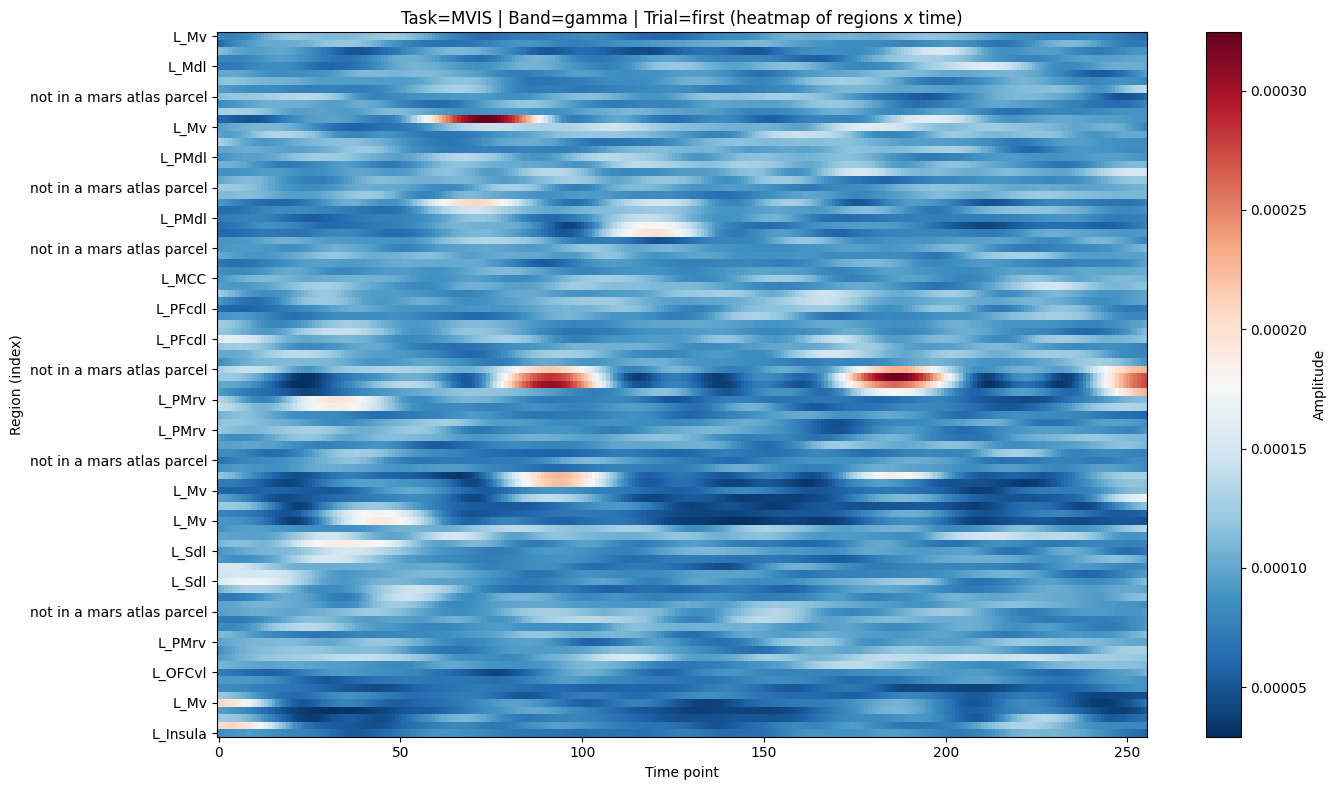

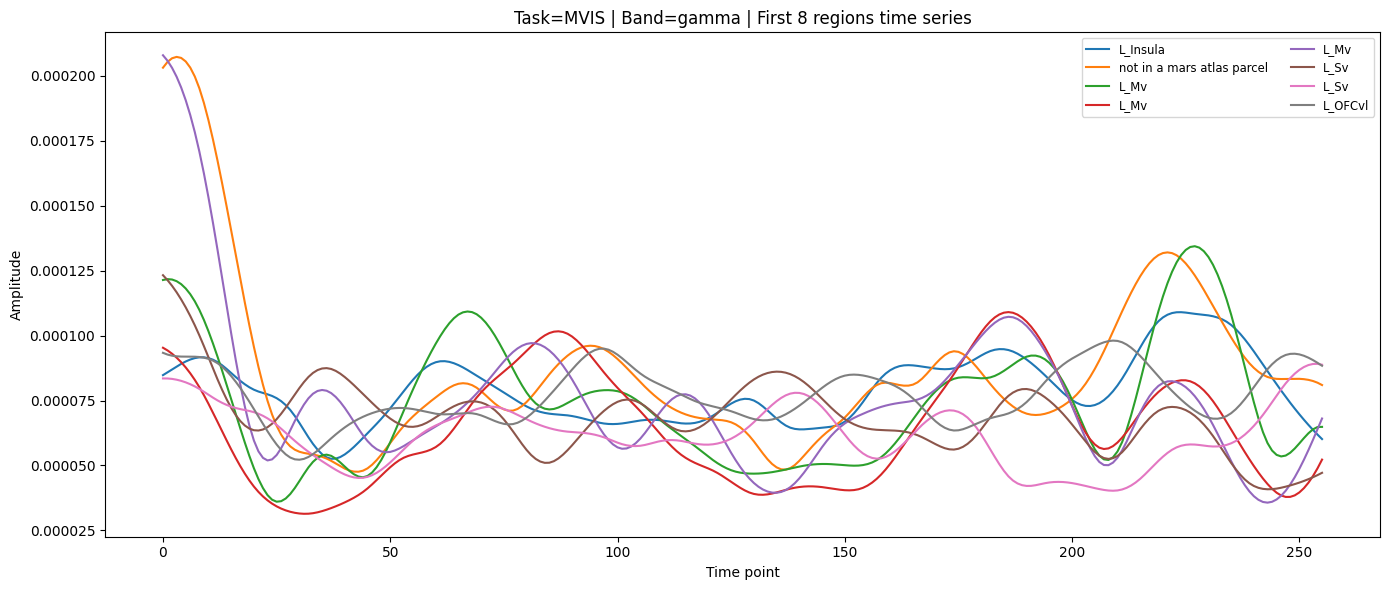

Band beta: data shape = (93, 256)


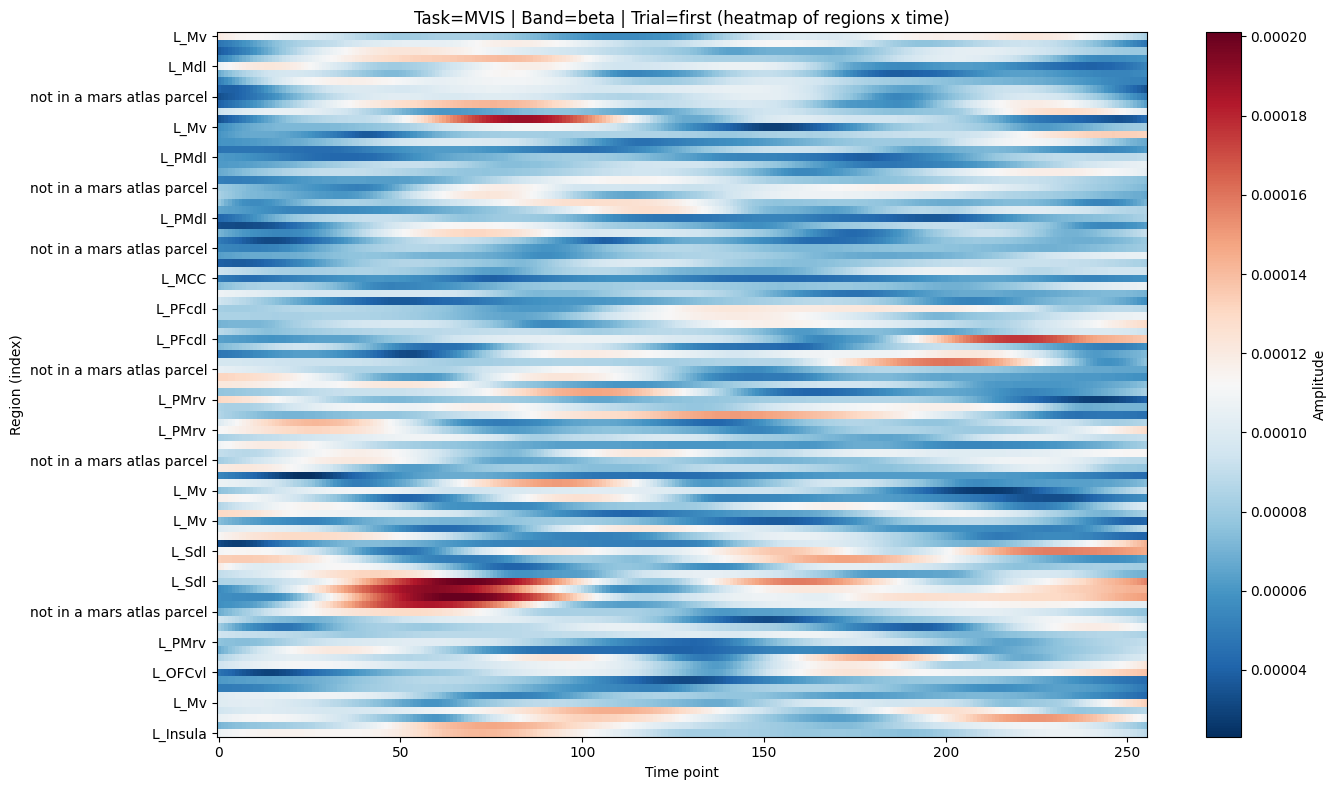

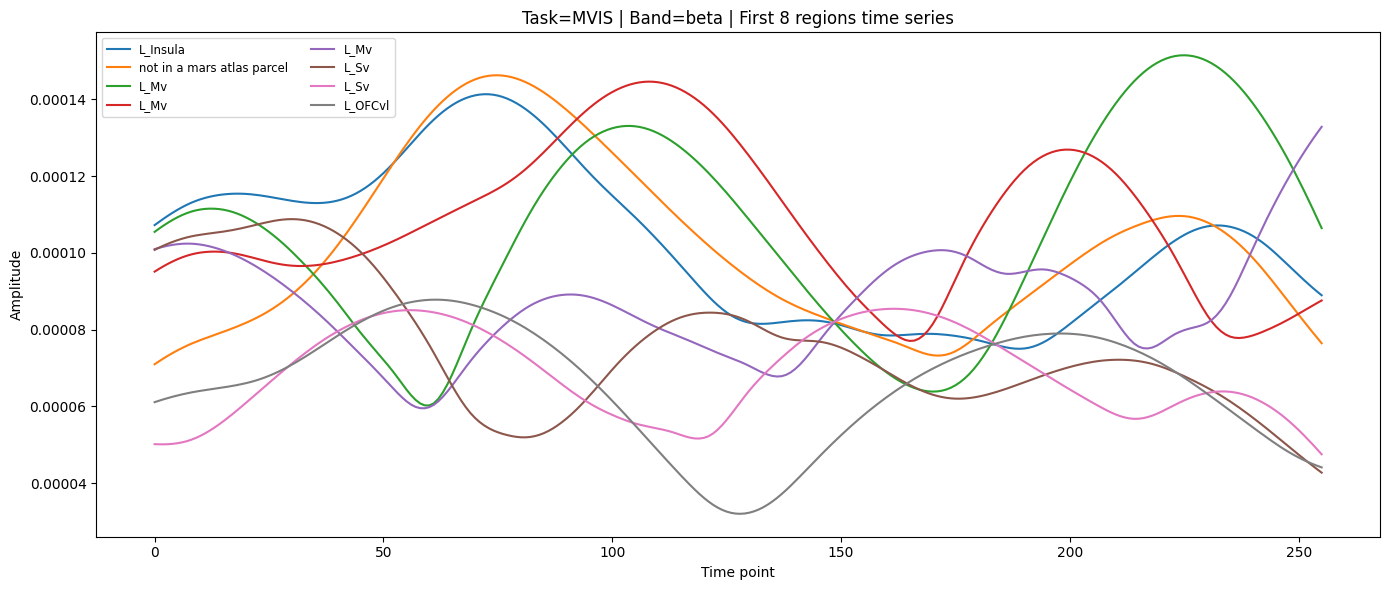

In [6]:
# Example plots: show test_array for one task and all regions for gamma and beta band
import matplotlib.pyplot as plt
import numpy as np

# Select the first available task from test_array
task = test_array.task.values[0]
print('Selected task:', task)

# Find bands matching gamma and beta (case-insensitive). If none match, fall back to the first two bands.
bands_available = [str(b) for b in test_array.band.values]
bands_to_plot = [b for b in bands_available if ('gamma' in b.lower() or 'beta' in b.lower())]
if not bands_to_plot:
    bands_to_plot = bands_available[:2]
print('Bands to plot:', bands_to_plot)

for band in bands_to_plot:
    # select data for the chosen task and band
    sel = test_array.sel(task=task, band=band, event="encod")
    # pick the first trial to visualise (or mean over trials if you prefer)
    try:
        sel_trial = sel.isel(trial=0)
    except Exception:
        sel_trial = sel

    # sel_trial should have dims (region, time); convert to 2D arra
    data = sel_trial.values
    print(f"Band {band}: data shape = {data.shape}")

    # Plot heatmap (regions x time)
    plt.figure(figsize=(14, 8))
    plt.imshow(data, aspect='auto', origin='lower', cmap='RdBu_r')
    plt.colorbar(label='Amplitude')
    plt.ylabel('Region (index)')
    plt.xlabel('Time point')
    plt.title(f"Task={task} | Band={band} | Trial=first (heatmap of regions x time)")

    # reduce y tick labels to avoid overcrowding
    n_regions = data.shape[0]
    ticks = np.arange(0, n_regions, max(1, n_regions // 20))
    plt.yticks(ticks, [sel_trial.region.values[i] for i in ticks])
    plt.tight_layout()
    plt.show()

    # also plot a few example region time series (first 8 regions)
    n_examples = min(8, data.shape[0])
    plt.figure(figsize=(14, 6))
    for i in range(n_examples):
        plt.plot(data[i], label=str(sel_trial.region.values[i]))
    plt.legend(ncol=2, fontsize='small')
    plt.xlabel('Time point')
    plt.ylabel('Amplitude')
    plt.title(f"Task={task} | Band={band} | First {n_examples} regions time series")
    plt.tight_layout()
    plt.show()

## Ready with playing with the data - Let's start some analysis

- group the data accordingly:
    - task, band, event, feedback
- let's run some dyca

In [ ]:
# delete trial 35
cleaned_array = test_array.sel(trial=test_array.trial != 35)

# count nans and notnans in the cleaned data
nans_cleaned = np.isnan(cleaned_array).sum().item()
notnans_cleaned = np.count_nonzero(~np.isnan(cleaned_array))
print(f"Number of NaNs in the cleaned data array: {nans_cleaned}")
print(f"Number of non-NaNs in the cleaned data array: {notnans_cleaned}")

In [ ]:
# look at the regions 
print(cleaned_array.region.values)
unique_regions = set(cleaned_array.region.values)
print(unique_regions)


In [ ]:
# look at the rank of every single trial
ranks = []
for trial in cleaned_array.trial.values:
    trial_data = cleaned_array.sel(trial=trial)
    for i in range(trial_data.shape[0]): # task
        for j in range(trial_data.shape[1]): # band
            for k in range(trial_data.shape[2]): # event
                region_time_matrix = trial_data[i, j, k, :, :].values # shape (93, 256)
                if np.isnan(region_time_matrix).all():
                    rank = 0
                else:
                    rank = np.linalg.matrix_rank(np.nan_to_num(region_time_matrix))
                ranks.append((trial, cleaned_array.task[i].item(), cleaned_array.band[j].item(), cleaned_array.event[k].item(), rank))
                
ranks_df = pd.DataFrame(ranks, columns=['trial', 'task', 'band', 'event', 'rank'])
print(ranks_df)

# print the histogramm of the ranks
unique, counts = np.unique(ranks_df['rank'], return_counts=True)
rank_histogram = dict(zip(unique, counts))
print("\nHistogram of ranks:")
for rank, count in sorted(rank_histogram.items()):
    print(f"Rank {rank}: {count} occurrences")
    
    

In [ ]:
# group the data by task, band, event, feedback (so we have at the end 24 arrays)
# Get unique values for each dimension
tasks = cleaned_array.task.values
bands = cleaned_array.band.values
events = cleaned_array.event.values

print(f"Tasks: {tasks}")
print(f"Bands: {bands}")
print(f"Events: {events}")
print(f"Shape: {cleaned_array.shape}")


# Create grouped arrays for each combination
grouped_arrays = {}

for task in tasks:
    for band in bands:
        for event in events:
                group_name = f"task_{task}_band_{band}_event_{event}"
                
                # Select data for this specific combination
                group_data = cleaned_array.sel(
                    task=task,
                    band=band,
                    event=event
                )
                
                grouped_arrays[group_name] = group_data
                print(f"Created group: {group_name}, shape: {group_data.shape}")

print(f"\nTotal number of groups created: {len(grouped_arrays)}")

In [ ]:
# calculate mean over the trials for each group
mean_grouped_arrays_trails = {}
for group_name, group_data in grouped_arrays.items():
    mean_data = group_data.mean(dim='trial')
    mean_grouped_arrays_trails[group_name] = mean_data
    print(f"Calculated mean for group: {group_name}, shape: {mean_data.shape}")

In [ ]:
# calculate rank for each mean group
ranked_grouped_arrays = {}
for group_name, mean_data in mean_grouped_arrays_trails.items():
    rank_of_data = np.linalg.matrix_rank(mean_data)
    ranked_grouped_arrays[group_name] = rank_of_data
    print(f"Calculated rank for group: {group_name}, rank: {rank_of_data}, full shape: {mean_data.shape}")

In [ ]:
###  This code works technically, but it is not very useful, because there are no non_variance channels nor duplicate channels

# def find_duplicate_channels(X, channel_names=None, tol=1e-8):
#     if channel_names is None:
#         channel_names = [f"ch{i}" for i in range(X.shape[0])]

#     corr = np.corrcoef(X)
#     dup_pairs = []
#     n = len(channel_names)
#     for i in range(n):
#         for j in range(i+1, n):
#             if np.abs(corr[i, j] - 1.0) < tol:
#                 dup_pairs.append((channel_names[i], channel_names[j]))
#     return dup_pairs

# # if the rank is not full, we need to delete the double regions
# cleaned_ranked_grouped_arrays = {}
# threshold_var = 1e-12
# for group_name, rank in ranked_grouped_arrays.items():
#     # change the region names to: regionname_1, regionname_2, ...
#     region_names = [f"{name}_{i}" for i, name in enumerate(mean_grouped_arrays[group_name].region.values)]
#     mean_data = mean_grouped_arrays[group_name]
#     full_rank = min(mean_data.sizes['region'], mean_data.sizes['time'])
#     if rank < full_rank:
#         print(f"Group {group_name} has rank {rank} which is less than full rank {full_rank}. Cleaning...")
#         # find channels with low variance
#         var = np.var(mean_data.values, axis = 1)
#         mask_var = var > threshold_var
#         cleaned_data = mean_data.values[mask_var, :]
#         cleaned_rank = np.linalg.matrix_rank(cleaned_data)
#         print(f"After cleaning (low variance), new shape: {cleaned_data.shape}, new rank: {cleaned_rank}")
#         # find duplicate channels  
#         cleaned_region_names = [region_names[i] for i in range(len(region_names)) if mask_var[i]]
#         dup_channels = find_duplicate_channels(cleaned_data, channel_names=cleaned_region_names, tol=1e-1)
#         print(f"Duplicate channels found: {dup_channels}")
#         print(f"How many duplicate channels: {len(dup_channels)}\n")

In [ ]:
# other idea: calculate the mean of every region over time (because some regions are the same, but from different electrodes)
# then calculate the rank of this mean matrix (regions x mean over time)
mean_over_regions_grouped_arrays = {}

for group_name, group_data in mean_grouped_arrays_trails.items():
    mean_over_regions_grouped_arrays[group_name] = {}
    # falls region Koordinate ist:
    unique_regions = np.unique(group_data['region'].values)

    for unique_region in unique_regions:
        region_sel = group_data.sel(region=unique_region)
        if len(region_sel.shape) == 1:
            # extent the shape
            region_sel = np.expand_dims(region_sel, axis=0)
            # print(region_sel.shape)
        region_mean = np.mean(region_sel, axis=0)  # mean over region
        if len(region_mean.shape) == 0:
            print(region_mean.shape)
            print(region_sel.shape)
        # print(region_mean.shape)
        mean_over_regions_grouped_arrays[group_name][unique_region] = region_mean
mean_over_regions_grouped_arrays[group_name].keys()

In [ ]:
# now calculate the rank of each group
ranked_mean_over_regions_grouped_arrays = {}
for group_name, region_dict in mean_over_regions_grouped_arrays.items():
    region_means_matrix = np.array(list(region_dict.values()))  # shape (n_regions, n_timepoints)
    rank_of_data = np.linalg.matrix_rank(region_means_matrix)
    ranked_mean_over_regions_grouped_arrays[group_name] = rank_of_data
    print(f"Calculated rank for group: {group_name}, rank: {rank_of_data}, full shape: {region_means_matrix.shape}")


The Variable `mean_over_regions_grouped_arrays` contains now a grouped array, full rank

In [ ]:
# Run dyca on the first trial of each group
dyca_results = {}
for group_name, region_dict in mean_over_regions_grouped_arrays.items():
    data = np.array(list(region_dict.values()))  # shape (n_regions, n_timepoints)    
    print(f"Running dyca on group: {group_name}, data shape: {data.shape}")
    
    # Run dyca
    time = np.linspace(0, 1, 256)
    dyca_result = dyca.dyca(data.T, time)
    dyca_results[group_name] = dyca_result
    print(f"dyca completed for group: {group_name}")

In [ ]:
# plot the dyca eigenvalues for each group
import matplotlib.pyplot as plt
# %matplotlib notebook

for group_name, dyca_result in dyca_results.items():
    plt.figure()
    plt.bar(range(len(dyca_result['generalized_eigenvalues'])), dyca_result['generalized_eigenvalues'])
    plt.title(f"DyCA Eigenvalues for {group_name}")
    plt.xlabel("Component")
    plt.ylabel("Eigenvalue")
    plt.grid()
    plt.show()